In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wednesday October 10 10:11:42 2023
Example Code for training an MRI Image Reconstruction Network from Inter4k Dataset

Three networks and trajectories were investigated: 
- Cartesian real-time with unrolled VarNet [ref] -> model_type='VarNet'
- Radial real-time with multicoil 3DUNet [ref] -> model_type='3DUNet'
- Low latency spiral imaging with FastDVDNet (Hyperslice [ref]) -> model_type='FastDVDNet'

Provided code includes trajectories, model training and pre-trained models as implemented for the paper.

Methods details in : 
Investigating the use of high spatio-temporal resolution publicly available natural videos to learn Dynamic MR image reconstruction

@author: Dr. Olivier Jaubert
"""
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
import numpy as np
import tensorflow as tf
try:  tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
except: print('running on CPU')
import tensorflow_mri as tfmri
import random
import matplotlib.pyplot as plt
import datetime
import json
# # Local imports (works if you are in project folder)
import utils.create_tensorflow_dataset as dataset_utils
import utils.model_utils as model_utils
import utils.display_function as display_func

#Choose model_type
result_folder='TrainingFolder'
model_type='FastDVDNet'
DEBUG=False

#Set seed for all packages
seed_value=1
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
;

2023-11-07 14:37:38.141447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 14:37:38.255230: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 14:37:40.309363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-07 14:37:40.311395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-07 14:37

''

In [2]:
exp_name='Default_'+model_type if not DEBUG else 'Default_'+model_type+'_DEBUG'
data_folder = './DatasetFolder/Inter4K/60fps/UHD/'
cache_dir = './DatasetFolder/DEBUG/' if DEBUG else './DatasetFolder/'

#Total number of samples from dataset used 
n= 12 if DEBUG else 692

#Reset parameter: 
#2 for full repreprocessing from original Inter4K.
#1 from preprocessed resized video (recommended).
#0 from cached data from previous run.
reset=1

#Selecting files and splitting train/val/test 
filenames_datasets=dataset_utils.split_training_test_set(data_folder,n=n,split=[0.75,0.10,0.15],verbose=1)
#Resizing Original Inter4K videos
preproc_datasets=dataset_utils.run_load_preproc_dataset(filenames_datasets,cache_dir,reset=reset)
#Creating Datasets Corresponding to Acquisition and reconstruction method
if model_type=='VarNet':
    dataset_withtransforms=dataset_utils.generate_dataset_VarNet(preproc_datasets,cache_dir,reset=reset,DEBUG=DEBUG)
elif model_type=='3DUNet':
    dataset_withtransforms=dataset_utils.generate_dataset_radial3DUNet(preproc_datasets,cache_dir,reset=reset,DEBUG=DEBUG)
elif model_type=='FastDVDNet':
    dataset_withtransforms=dataset_utils.generate_dataset_FastDVDNet(preproc_datasets,cache_dir,reset=reset,DEBUG=DEBUG)
else:
    print('model_type: ',model_type,' not supported')

100%|██████████| 1000/1000 [00:00<00:00, 3363515.64it/s]


Total/Train/Val/Test: 12 / 9 / 1 / 2 leftovers: 0


2023-11-07 14:37:52.299278: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7464960000 exceeds 10% of free system memory.


Config natural image to kspace: {'base_resolution': 240, 'phases': 12, 'masking': True, 'regsnr': [12, 22], 'sigma_coil': [2, 6], 'complex_transform': 4, 'num_coils': [30], 'add_phase': 2} 
Config preprocessing: {'base_resolution': 240, 'phases': 12, 'roll': 0, 'input_format': 'abs', 'output_format': 'abs', 'normalize_input': False} 
Config traj: {'flow': 0, 'base_resolution': 240, 'field_of_view': 400, 'phases': 12, 'ordering': 'linear', 'max_tempres': 55, 'min_max_arm_time': [0.88, 1.67], 'vd_spiral_arms': 16, 'vd_inner_cutoff': 0.15, 'pre_vd_outer_cutoff': 0.41288, 'vd_outer_density': 0.07, 'vd_type': 'hanning', 'max_grad_ampl': 22.0, 'min_rise_time': 10.0, 'dwell_time': 1.4, 'gradient_delay': 0.56, 'readoutOS': 2.0, 'deadtime': 2.0, 'reverse': True}


2023-11-07 14:38:03.928516: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7464960000 exceeds 10% of free system memory.
2023-11-07 14:38:06.716527: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-07 14:38:10.681414: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7440076800 exceeds 10% of free system memory.


In [3]:
inputs_temp=next(iter(dataset_withtransforms[0].take(1)))

config_model=dict()
#To modify model architecture:
# config_model={'filters': [16,32,46,64]}

learning_params=dict()
#To modify learning params :
# learning_params={'learning_rate': 0.005}

model=model_utils.load_models(inputs_temp,model_type,DEBUG=DEBUG)
learning_params=model_utils.load_learning_params(model_type,DEBUG=DEBUG,learning_params=learning_params)
print(learning_params)
model.compile(optimizer=learning_params['optimizer'],
                    loss=learning_params['loss'],
                    metrics=learning_params['metrics'],
                    run_eagerly=False)
model.summary()

2023-11-07 14:38:40.790172: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7464960000 exceeds 10% of free system memory.
2023-11-07 14:38:47.603784: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7440076800 exceeds 10% of free system memory.
2023-11-07 14:38:50.043404: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-07 14:38:50.048385: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if y

(1, 240, 240, 5)
{'learning_rate': 0.0001, 'loss': <tensorflow_mri.python.losses.iqa_losses.SSIMLoss object at 0x7fef49336610>, 'epochs': 3, 'metrics': [<tensorflow_mri.python.metrics.iqa_metrics.PSNR object at 0x7feb00604310>, <tensorflow_mri.python.metrics.iqa_metrics.SSIM object at 0x7feac0514910>], 'optimizer': <keras.optimizers.optimizer_v2.adam.Adam object at 0x7feac0527bb0>}
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 5)]     0         
                                                                 
 fast_dvd_net (FastDVDNet)   (None, 240, 240, 1)       1589506   
                                                                 
Total params: 1,589,506
Trainable params: 1,589,506
Non-trainable params: 0
_________________________________________________________________


In [4]:
#Defining Paths
exp_name += '_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
exp_dir = os.path.join(result_folder, exp_name)

callbacks=[]
checkpoint_filepath=os.path.join(exp_dir,'ckpt/saved_model')
callbacks.append(tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        mode='min',
        save_weights_only=False,
        save_best_only=True))
callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=os.path.join(exp_dir,'logs')))

In [5]:
#Train Model
history=model.fit(dataset_withtransforms[0],
          epochs=learning_params['epochs'],
          verbose=1,
          callbacks=callbacks,
          validation_data=dataset_withtransforms[1]
          )

Epoch 1/3


2023-11-07 14:38:55.017703: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-07 14:38:55.018164: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-07 14:39:07.144835: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


9/9 [==============================] - ETA: 0s - loss: 0.6828 - psnr: 17.6991 - ssim: 0.3172

2023-11-07 14:40:04.284619: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-07 14:40:08.332510: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-07 14:40:08.332976: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. I

INFO:tensorflow:Assets written to: TrainingFolder/Default_FastDVDNet_20231107_143851/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: TrainingFolder/Default_FastDVDNet_20231107_143851/ckpt/saved_model/assets


9/9 [==============================] - 84s 9s/step - loss: 0.6828 - psnr: 17.6991 - ssim: 0.3172 - val_loss: 0.5886 - val_psnr: 18.9463 - val_ssim: 0.4114
Epoch 2/3
7/9 [======================>.......] - ETA: 0s - loss: 0.5439 - psnr: 19.2510 - ssim: 0.4561

2023-11-07 14:40:22.007765: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-07 14:40:22.385710: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


INFO:tensorflow:Assets written to: TrainingFolder/Default_FastDVDNet_20231107_143851/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: TrainingFolder/Default_FastDVDNet_20231107_143851/ckpt/saved_model/assets


9/9 [==============================] - 6s 782ms/step - loss: 0.5450 - psnr: 19.5861 - ssim: 0.4550 - val_loss: 0.5039 - val_psnr: 22.9714 - val_ssim: 0.4961
Epoch 3/3
7/9 [======================>.......] - ETA: 0s - loss: 0.4983 - psnr: 20.6897 - ssim: 0.5017

2023-11-07 14:40:28.281187: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-07 14:40:28.656655: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


INFO:tensorflow:Assets written to: TrainingFolder/Default_FastDVDNet_20231107_143851/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: TrainingFolder/Default_FastDVDNet_20231107_143851/ckpt/saved_model/assets


9/9 [==============================] - 7s 831ms/step - loss: 0.4968 - psnr: 20.5255 - ssim: 0.5032 - val_loss: 0.3199 - val_psnr: 22.5537 - val_ssim: 0.6801


2023-11-07 14:40:31.606418: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


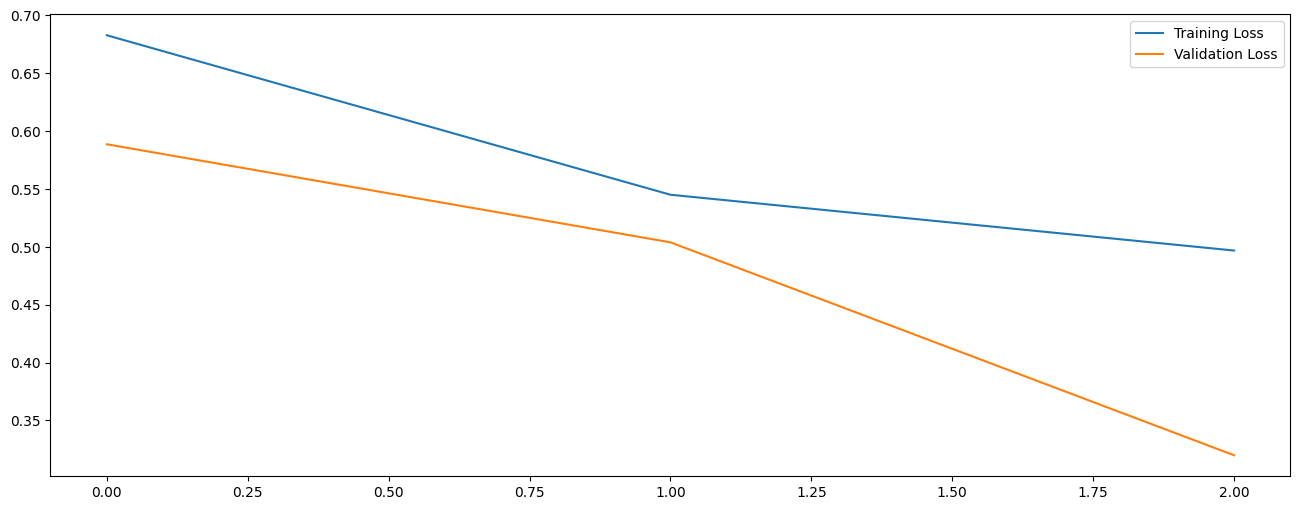

In [6]:
fig = plt.figure(figsize=(16,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
leg = plt.legend()

In [14]:
#Evaluate On Test Set
checkpoint_filepath=os.path.join(exp_dir,'ckpt/saved_model')
model.load_weights(checkpoint_filepath)
result = model.evaluate(dataset_withtransforms[2])
if model_type=='VarNet':
    results_dict={model.metrics_names[0]: result} #when only 1 metric
else:
    results_dict=dict(zip(model.metrics_names, result))
filename = os.path.join(exp_dir,'results.json')
with open(filename, 'w') as f:
    f.write(json.dumps(results_dict))

2023-11-07 14:44:43.735850: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open TrainingFolder/Default_FastDVDNet_20231107_143851/ckpt/saved_model: FAILED_PRECONDITION: TrainingFolder/Default_FastDVDNet_20231107_143851/ckpt/saved_model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


2/2 [==============================] - 4s 234ms/step - loss: 0.3915 - psnr: 22.2053 - ssim: 0.6085


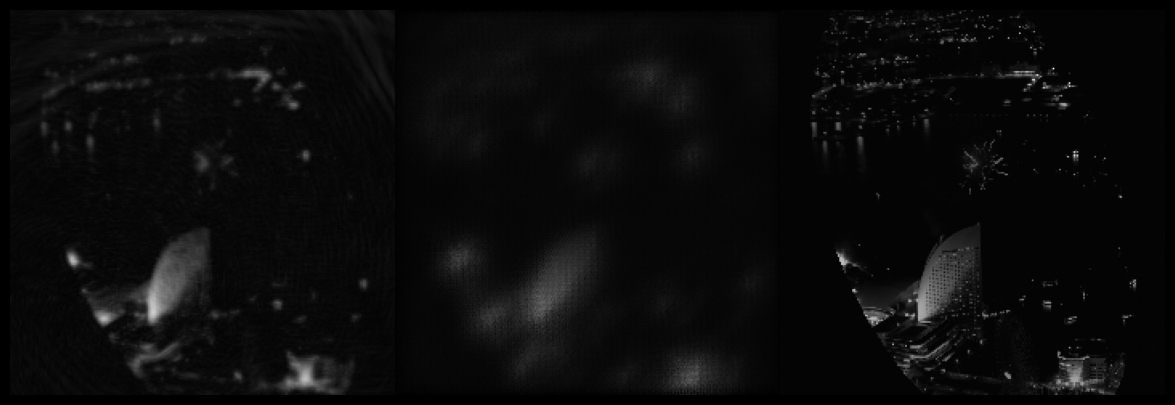

In [16]:
#Inference
#Preproc series 1
if DEBUG:
    ntestimage=0
else:
    ntestimage=9
bg_color='k'
if model_type=='VarNet':
    inputs=next(iter(dataset_withtransforms[-1].skip(ntestimage)))
    output = model(inputs)
    zfill=tf.complex(inputs[0][0,...,0],inputs[0][0,...,1])
    gt=tf.complex(inputs[-1][0,...,0],inputs[-1][0,...,1])
    output=tf.complex(output[0,...,0],output[0,...,1])
elif model_type=='3DUNet':
    inputs,gt=next(iter(dataset_withtransforms[-1].skip(ntestimage)))
    output = model(inputs)
    zfill=tf.complex(inputs[0,...,:10],inputs[0,...,10:])
    zfill=np.sqrt(np.sum(zfill*np.conj(zfill),axis=-1))
    gt=gt[0,...,0]
    output=output[0,...,0]
elif model_type=='FastDVDNet':
    inputs,gt=next(iter(dataset_withtransforms[-1].skip(ntestimage)))
    output = model(inputs)
    zfill=inputs[0,...,-1]
    gt=gt[0,...,0]
    output=output[0,...,0]

#From Left to Right: Input, Ground Truth, Reconstructed.
if model_type=='FastDVDNet':
    savepath=os.path.join(exp_dir,'test_image_'+str(ntestimage)+'_'+model_type)
    plot_image=np.abs(np.concatenate((zfill,output,gt),axis=1))
    plt.figure(figsize=(15,5),facecolor=bg_color)
    plt.imshow(plot_image,vmin=0,vmax=1,cmap='gray')
    plt.axis('off')
    plt.savefig(savepath)
else:
    savepath=os.path.join(exp_dir,'test_video_'+str(ntestimage)+'_'+model_type)
    plot_image=np.abs(np.concatenate((zfill,output,gt),axis=2))
    display_func.plotVid(plot_image,axis=0,vmin=0,vmax=1,interval=41.66,savepath=savepath,bg_color=bg_color)